## Libraries
business as usual

In [2]:
# standard libraries
import string
import re
import numpy as np
import pandas as pd

# data visualization
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

# sklearn for test train splits
from sklearn.model_selection import train_test_split

# Ridge regression
from sklearn.linear_model import Ridge
from sklearn.pipeline import make_union


## Loading kaggle data_sets into Pandas dataframes

In [3]:
# tsv is tab separeted so... delimiter='\t'
data_set = pd.read_csv('Data/train.tsv', delimiter='\t', encoding='utf-8')

# test_set not required yet 
# test_set = pd.read_csv('Data/test.tsv', delimiter='\t', encoding='utf-8')
# test_stg2 = pd.read_csv('Data/test_stg2.tsv', delimiter='\t', encoding='utf-8')

# check pandas dataframe dimension
print('Data frames loaded:')
print('data_set shape:', data_set.shape)
# print('test_set shape:', test_set.shape)
# print('test_stg2 shape:', test_stg2.shape)

Data frames loaded:
data_set shape: (1482535, 8)


## Data fields for reference:
(from kaggle competition)

The files consist of a list of product listings. These files are tab-delimited.
* train_id or test_id - the id of the listing
* <b>name</b> - the title of the listing. Note that we have cleaned the data to remove text that look like prices to avoid leakage. These removed prices are represented as [rm]
* <b>item_condition_id</b> - the condition of the items provided by the seller, 1=Good,...,5=Poor
* <b>category_name</b> - category of the listing
* <b>brand_name</b>
* <b>price</b> - the price that the item was sold for. This is the target variable that you will predict. The unit is USD. This column doesn't exist in test.tsv since that is what you will predict.
* <b>shipping</b> - 1 if shipping fee is paid by seller and 0 by buyer
* <b>item_description</b> - the full description of the item. Note that we have cleaned the data to remove text that look like prices to avoid leakage. These removed prices are represented as [rm]

## Data exploration - visualization

Summary so far:
 * There are unique <b>4,810</b> brands.
 * There are <b>82,489</b> items with <b>"No description yet"</b>, around 6% of our dataset. (what you think)
 * There are <b>874</b> entries with <b>price = 0/free</b>, should we drop them? as it does not make sence and will confuse our model I think.
 * prices are skewed to the right.
 * top brands (PINK, Nike, Victoria's Secret, etc)
     * Note there are <b>632,682</b> items with no brand assigned ~ 43% of our training set!

In [16]:
# display top rows
data_set.head(5)

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,,10.0,1,No description yet
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,,35.0,1,New with tags. Leather horses. Retail for [rm]...
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,,44.0,0,Complete with certificate of authenticity


In [13]:
# group by brands and check the most popular
brands = data_set.groupby(['brand_name']).size()

print('There are unique brands:', brands.shape[0])
print('of which {} have no brand assigned'.format(data_set[data_set['brand_name'].isnull()].shape[0]))

brands.sort_values(ascending=False).head(20)

There are unique brands: 4808
of which 0 have no brand assigned


brand_name
                     632336
PINK                  54072
Nike                  54006
Victoria's Secret     48011
LuLaRoe               30995
Apple                 17314
FOREVER 21            15178
Nintendo              14998
Lululemon             14550
Michael Kors          13916
American Eagle        13245
Rae Dunn              12300
Sephora               12164
Coach                 10458
Disney                10352
Bath & Body Works     10350
Adidas                10195
Funko                  9233
Under Armour           8458
Sony                   7992
dtype: int64

In [14]:
# items with no description
no_description = data_set[data_set['item_description']=='No description yet']

print('There are {} items with no description'.format(no_description.shape[0]))
no_description.head(5)

There are 82427 items with no description


,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,,10.0,1,No description yet
13,13,Sharpener and eraser,1,Other/Office supplies/School Supplies,Scholastic,4.0,1,No description yet
31,31,"New Lularoe OS leggings, stars",1,"Women/Athletic Apparel/Pants, Tights, Leggings",,50.0,1,No description yet
90,90,Jewel holder,2,Home/Storage & Organization/Jewelry Boxes & Or...,Target,7.0,1,No description yet
117,117,Eyeko liquid eyeliner,1,Beauty/Makeup/Eyes,,5.0,1,No description yet


<Figure size 1080x360 with 0 Axes>

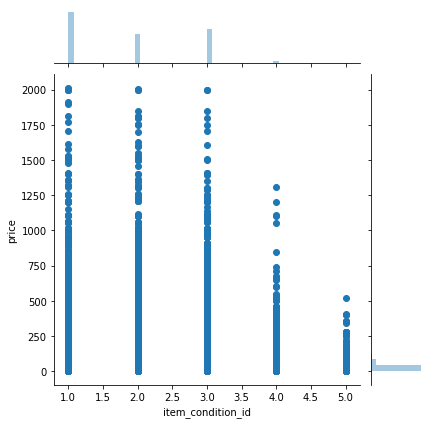

In [11]:
# looking for correlations between price and item condition
# expect to get higher price from items in condition = 1, cheaper as condition = 5
# not very clear correlation

plt.figure(figsize=(15,5))
sns.jointplot(x="item_condition_id", y="price", data=data_set)
plt.show()

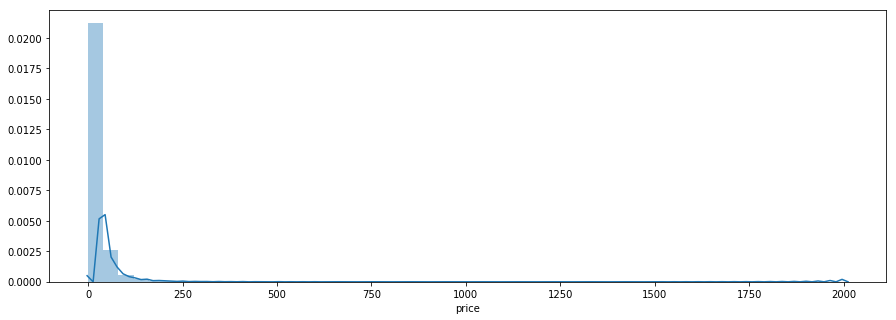

In [8]:
# see prices, everything seems to be on the "cheaper side"
plt.figure(figsize=(15,5))
ax = sns.distplot(data_set['price'])
plt.show()

# Data wrangling

* There are <b>874</b> entries with <b>price = 0/free</b>, should we drop them? as it does not make sence and will confuse our model I think.
* Replace <b>NaN</b> values with empty spaces?

In [9]:
# free items??? price == 0
data_set[data_set['price']==0].head(5)

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
1325,1325,Alabama Crimson Tide Quality Lanyard,1,Sports & Outdoors/Fan Shop/NCAA,NaN,0.0,1,TOP QUALITY THICK LANYARD Reversible sides wit...
2544,2544,Levi leggings,3,"Women/Jeans/Slim, Skinny",Levi's®,0.0,0,Light wash. Hardly worn. Size 24 but fits like...
2712,2712,Simple Red Lace Lingerie Top,3,Women/Underwear/G-Strings & Thongs,NaN,0.0,0,"Very simple but cute, a little form fitting as..."
3576,3576,Turquoise 15 Pc Makeup Brush Set,1,Beauty/Tools & Accessories/Makeup Brushes & Tools,NaN,0.0,1,1 left!
3761,3761,Girls size 7/8,3,Kids/Girls (4+)/Tops & T-Shirts,NaN,0.0,1,5 pair gap jean excellent used condition 3 chi...


In [10]:
# data cleansing

# replace NaN values with empty cells
data_set = data_set.fillna('')
# keep only items that have a price
data_set = data_set[data_set['price']!=0]

data_set.head(10)

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,,10.0,1,No description yet
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,,35.0,1,New with tags. Leather horses. Retail for [rm]...
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,,44.0,0,Complete with certificate of authenticity
5,5,Bundled items requested for Ruie,3,Women/Other/Other,,59.0,0,"Banana republic bottoms, Candies skirt with ma..."
6,6,Acacia pacific tides santorini top,3,Women/Swimwear/Two-Piece,Acacia Swimwear,64.0,0,Size small but straps slightly shortened to fi...
7,7,Girls cheer and tumbling bundle of 7,3,Sports & Outdoors/Apparel/Girls,Soffe,6.0,1,You get three pairs of Sophie cheer shorts siz...
8,8,Girls Nike Pro shorts,3,Sports & Outdoors/Apparel/Girls,Nike,19.0,0,Girls Size small Plus green. Three shorts total.
9,9,Porcelain clown doll checker pants VTG,3,Vintage & Collectibles/Collectibles/Doll,,8.0,0,I realized his pants are on backwards after th...
